In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('./complexPyTorch')

from complexLayers import ComplexConv2d, ComplexLinear, NaiveComplexBatchNorm2d , ComplexMaxPool2d , ComplexBatchNorm2d , ComplexDropout2d
from complexLayers import ComplexReLU
from complexFunctions import complex_relu , complex_matmul , complex_avg_pool2d

## Simulation description

## Description of the simulation 

* Illumination of a thin multiply scattering medium  
* SLM used for wavefront manipulation
* CCD camera for detecting the speckle 
* The SLM and the detector are located very close to the scattering sample  
* Total internal reflexion inside the waveguide is assumed

<img src='https://www.dropbox.com/s/yd0vdfme95zi4y4/dessin.png?dl=0&raw=1' width=700>

In [2]:
def bin2arr(path, Nmodes, Nconf):
    return torch.from_numpy(np.fromfile(path, dtype=np.float64).reshape(Nconf,Nmodes,Nmodes)).type(torch.float32)

N_confs = 192
N_modes = 387

t_re = bin2arr('../RGF/t_re.res', N_modes, N_confs)  
t_im = bin2arr('../RGF/t_im.res', N_modes, N_confs)
r_re = bin2arr('../RGF/r_re.res', N_modes, N_confs)
r_im = bin2arr('../RGF/r_im.res', N_modes, N_confs) 

# combine real and imaginary part to get complex tensors
# + send them to the GPU
pt_r_modes = (r_re +1j*r_im)
pt_t_modes = (t_re +1j*t_im)
# print(pt_r_modes.shape)

# change of basis matrix from mode to space
M0 = torch.from_numpy(np.loadtxt('../RGF/ModeToSpace_Nmodes=387_Nspace=1999.dat')).type(torch.complex64)
# change of basis matrix from space to mode
M1 = torch.from_numpy(np.loadtxt('../RGF/SpaceToMode_Nmodes=387_Nspace=1999.dat')).type(torch.complex64)

# convert matrices to pixel basis
pt_r_space = M0@pt_r_modes@M1
pt_t_space = M0@pt_t_modes@M1

print(pt_r_space.shape)

torch.Size([192, 1999, 1999])


#### Average pooling is performed on the transmission and reception matrices in space 

In [3]:
T_space_av = complex_avg_pool2d(pt_t_space, 
                                kernel_size = 5,
                                stride = 5
                                )

R_space_av = complex_avg_pool2d(pt_r_space, 
                                kernel_size = 5,
                                stride = 5
                                )

print(T_space_av.shape)

torch.Size([192, 399, 399])


In [4]:
# parameters
PARAMS = {
    'batch_size':16,
    'learning_rate': 1e-3,
    'max_epochs':40,
    'mat_size':R_space_av.shape[-1]
    }
print(PARAMS['mat_size'])

399


In [5]:
def size_after_conv(N, kernel_size, stride, num_conv_layer):
    """
        function returning the size of H,W after a 
        convolutional layer with kernel_size and stride
    """
    
    for i in range(num_conv_layer):
        N = int((N-(kernel_size-1)-1)/stride)+1
        
    return N

print((size_after_conv(N = PARAMS['mat_size'], kernel_size = 5, 
                 stride = 2, num_conv_layer = 6)))

3


## Creating a focal spot from scattered light (R and T matrices)



### Objective : finding the correct wave phase pattern to apply to the beam incident on the sample to do single-point focusing on the detector 

To do it : optimizing the shape of the wavefront incident. We want to find the wavefront which creates a focal spot from scattered light at the **middle pixel**. An SLM is used for wavefront manipulation (see Figure above)



Since the propagation in the medium is assumed to be linear, the field observed at the p-th pixel (behind the scattering medium) is the linear superposition of contributions emitted from individual source elements (SLM pixels) :

\begin{equation*}
E_{p}^{out} = \sum_{n=1}^{N_{SLM}} t_{pn}E_{n}^{in}
\label{eq:light_prop} \tag{1}
\end{equation*}

where $n$ is a pixel on the SLM while m is the camera pixel index.

$t_{pn}$ is the medium's complex-valued transmission matrix at the $p$-th row and $n$-th column, it describes the linear relation between the incident and scattered field. 

Then, adopting a matrix formulation of $\eqref{eq:light_prop}$, we get : $\textbf{E}^{out}=T.\textbf{E}^{in}$, with $T$ the complex-valued transmission matrix.

The input and output fields are respectiviley expressed at the SLM plane and the camera plane.


We want to find the incident fields that focuses the light at the middle of the detector only from the reflection matrix. Hence, our model $f$ outputs the incident field $E^{in}$ from the reflection matrix $R$ only : 
$$\hat{E}^{in} = f(R)$$ 


In terms of pixels it means that we want to maximise the intensity at the pixel $p_t$ in the middle : $\underset{w}{\arg\max} |E_{p_t}^{out}|^2$ with $w$ the wieghts of the trained model. $E^{out}$ is obtained thanks to the transmission matrix


During each epoch of the training, we compute the loss function $loss = \frac{|E^{out}|^2}{|E_{p_t}^{out}|^2}$ and update the weights of the model so that the function is minimized.

During each epoch, the model is also passed on validation data (unseen data) to detect overfitting.



## Scalable model

Here we do not intend to learn the incident light field to focus on a single point on the detector of a single scattering meidum. INSTEAD, we build a model to learn the incident light field of **any** scattering medium. To do so, we learn the latter mapping by training on multiple scattering media (192) with different microstructures while having the same macroscopic parameter. This is done to have a scalable model.

## Network Architecture
<img src='https://www.dropbox.com/s/vtq5zl5ykrbpuqr/nn-11.png?dl=0&raw=1' width=700>

In [9]:
class Lit_net_1(pl.LightningModule):
    def __init__(self, mat_size):
        super().__init__()
        
        ## Convolutional layers
        
        
        self.conv1 = ComplexConv2d(in_channels = 1, 
                                   out_channels = 20, 
                                   kernel_size = 3, 
                                   padding = 1,
                                   )
        

        
        self.conv2 = ComplexConv2d(in_channels = 20, 
                                   out_channels = 50, 
                                   kernel_size = 3, 
                                   padding = 1,
                                   )
        
        self.conv3 = ComplexConv2d(in_channels = 50, 
                                   out_channels = 100, 
                                   kernel_size = 3, 
                                   padding = 1,
                                   )
        
        self.conv4 = ComplexConv2d(in_channels = 100, 
                                   out_channels = 150, 
                                   kernel_size = 3, 
                                   padding = 1,
                                   )
        
        self.conv5 = ComplexConv2d(in_channels = 150, 
                                   out_channels = 150, 
                                   kernel_size = 3, 
                                   padding = 1,
                                   )
        
        # batch normalization
        self.bn  = ComplexBatchNorm2d(20) 
        
        # pool layers
        self.pool = ComplexMaxPool2d(kernel_size = 5, stride=2)

        # non linearity
        self.activfunc_a = ComplexReLU()

        # fully connected layers - at the end
        flattened_dim = 150 * (size_after_conv(N = PARAMS['mat_size'],
                                               kernel_size = 5, 
                                               stride = 2, 
                                               num_conv_layer = 6
                                               ))**2
        self.fc1 = ComplexLinear(flattened_dim, 1024)
        
        self.dropout = ComplexDropout2d(p = 0.3)
 
        self.fc2 = ComplexLinear(1024, mat_size)

    def forward(self, x):
        
        x = self.activfunc_a(self.conv1(x))
        x = self.pool(x)

        x = self.bn(x)
    
        x = self.activfunc_a(self.conv2(x))
        x = self.pool(x)
        
        x = self.activfunc_a(self.conv3(x)) 
        x = self.pool(x)
        
        x = self.dropout(x)
        
        x = self.activfunc_a(self.conv4(x)) 
        x = self.pool(x)
        
        x = self.activfunc_a(self.conv5(x)) 
        x = self.pool(x)
        
        x = self.activfunc_a(self.conv5(x)) 
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=PARAMS['learning_rate'])
        return optimizer

    def training_step(self, train_batch, batch_idx):
        r, t = train_batch

        r = r.type(torch.complex64)
        self.input_shape = r.shape
        
        x_hat = self.forward(r) 

        x_hat = torch.unsqueeze(x_hat,dim=2)

        t = torch.squeeze(t)
        
        y = complex_matmul(t,x_hat)

        loss = (((torch.norm(y.abs(), dim=1))**2) / \
                ((y[:,int((y.shape[1])/2)].abs())**2)).mean()
        
        self.log('train_loss', loss)
        
        return {'loss':loss}

    def validation_step(self, val_batch, batch_idx):
        
        return self.training_step(val_batch, batch_idx)
    
    def validation_epoch_end(self, outputs):
        
        #  the function is called after  every epoch is completed
        
        if(self.current_epoch==1):
            sample_input=torch.rand(self.input_shape).type(torch.complex64)

        # calculating average loss 
        avg_val_loss = torch.stack([x['loss'] for x in outputs]).mean()
        
        self.log('avg_val_loss', avg_val_loss)
        
        return {'val_loss': avg_val_loss} # for early stopping 
    
    def training_epoch_end(self,outputs):
        #  the function is called after every epoch is completed
        
        if(self.current_epoch==1):
            sample_input=torch.rand(self.input_shape).type(torch.complex64)

        # calculating average loss 
        avg_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
        
        self.log('avg_train_loss', avg_train_loss)



In [19]:
# pt_r = pt_r_modes[:,None,...]
# pt_t = pt_t_modes[:,None,...]

pt_r = R_space_av[:,None,...]
pt_t = T_space_av[:,None,...]

r_dataset = TensorDataset(pt_r,pt_t)


N_tot = pt_r.shape[0]
test_fraction = 0.8
N_train = int(0.8 * N_tot)
N_val = N_tot - N_train

rt_train, rt_val = random_split(r_dataset, [N_train, N_val])

train_loader = DataLoader(rt_train, 
                          batch_size=PARAMS['batch_size'], 
                          num_workers=8)
val_loader = DataLoader(rt_val, 
                        batch_size=PARAMS['batch_size'],
                        num_workers=8)

# model
model = Lit_net_1(mat_size=PARAMS['mat_size'])



tb_logger = pl_loggers.TensorBoardLogger('logs/')


neptune_logger = pl_loggers.neptune.NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiNGE0ODg3N2ItN2EwMi00OTk5LWExMTYtNWE2NjVhNjhmNzY5In0=",
    project_name="octaveg5/testRT",
    params=PARAMS # save relevant paramters
    )



checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='../check_p/',
    filename='sample-TR-conjugate-focalize-tr-{epoch:02d}-{val_loss:.1f}',
    save_top_k=1,
    mode='min',
)

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.005,
   patience=3,
   verbose=True,
   mode='min'
)

# training
trainer = pl.Trainer(
    gpus=[1],
    progress_bar_refresh_rate=80,
    max_epochs=PARAMS['max_epochs'],
    logger = neptune_logger,
#     logger=False,
    callbacks=[checkpoint_callback,early_stop_callback],
#     callbacks=False,
    )
trainer.fit(model, train_loader, val_loader)

print("FINISHED TRAINING")

NeptuneLogger will work in online mode
/opt/miniconda/py3/envs/py38/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory ../check_p/ exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

   | Name        | Type               | Params
----------------------------------------------------
0  | conv1       | ComplexConv2d      | 400   
1  | conv2       | ComplexConv2d      | 18.1 K
2  | conv3       | ComplexConv2d      | 90.2 K
3  | conv4       | ComplexConv2d      | 270 K 
4  | conv5       | ComplexConv2d      | 405 K 
5  | bn          | ComplexBatchNorm2d | 100   
6  | pool        | ComplexMaxPool2d   | 0     
7  | activfunc_a | ComplexReLU        | 0     
8  | fc1         | ComplexLinear      | 2.8 M 
9  | dropout     | ComplexDropout2d   | 0     
10 | fc2         | ComplexLinear      | 817 K 
---------------

Validation sanity check: 0it [00:00, ?it/s]

/opt/miniconda/py3/envs/py38/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/octaveg5/testRT/e/TES-247


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb5984924c0>
Traceback (most recent call last):
  File "/opt/miniconda/py3/envs/py38/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/miniconda/py3/envs/py38/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
Exception ignored in:   File "/opt/miniconda/py3/envs/py38/lib/python3.8/multiprocessing/process.py", line 147, in join
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb5984924c0>    
assert self._parent_pid == os.getpid(), 'can only join a child process'Traceback (most recent call last):

  File "/opt/miniconda/py3/envs/py38/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
AssertionError: can only join a child process    
self._shutdown_workers()
  File "/opt/miniconda/py3/envs/py38/lib/python3.8

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

FINISHED TRAINING


In [20]:
model = Lit_net_1(mat_size = PARAMS['mat_size'])

checkpoint = torch.load('../check_p/sample-TR-conjugate-focalize-tr-epoch=39-val_loss=1.3.ckpt')

model.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

In [21]:
ind = 0
R_space_val, T_space_val = rt_val.__getitem__(ind)
R_space_train, T_space_train = rt_train.__getitem__(ind)

In [22]:
x_hat_v = model(R_space_val[:, None, ...]).squeeze()
x_hat_t = model(R_space_train[:, None, ...]).squeeze()

In order to evaluate the model's performance we apply our model to unseen data and compare it to the ground-truth incident field which is derived as follow :

We want to find $E^{in}$ so that $E^{out}$ is maximized at the middle pixel $p_t$. 

From equation (1), $$E_p^{out} = \sum_{n=1}^{N_{SLM}} t_{pn}E_{n}^{in} = \sum_{n=1}^{N_{SLM}} |t_{pn}|e^{\textit{j}arg(t_{pn})}|E_{n}^{in}|e^{\textit{j}arg(E_{n}^{in})}$$

in order to maximize this quantity at output pixel $p_t$ we need : $arg({t_{p_tn}})=-arg(E_{n}^{in})$. And for an arbitrarily chosen output pixel $p \neq p_t$, the output field is a sum of random phasors (see Figure (a) above). Therefore, the ground-truth incident field is $E_n^{in} = (t_{p_tn})^{*}$ the complex-conjugate of the $p_t$-th transmission matrix row.

$$E_p^{out} = \sum_{n=1}^{N_{SLM}} |t_{pn}||E_{n}^{in}|e^{\textit{j}(arg(t_{pn})-arg(t_{p_tn}))}$$

$$E_{p_t}^{out} = \sum_{n=1}^{N_{SLM}} |t_{pn}||E_{n}^{in}|$$

See Figure for an illustration.

<img src='https://www.dropbox.com/s/4tq0okfm5gizhnf/dessin3.png?dl=0&raw=1' width=500>

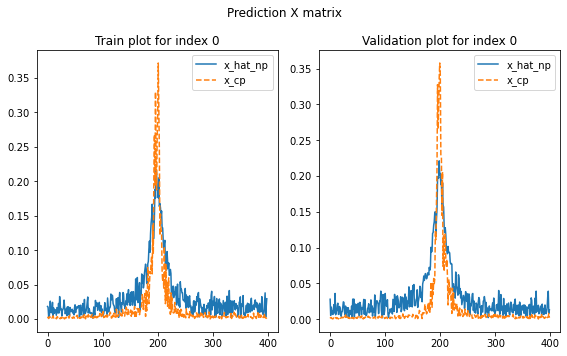

In [23]:
T_av_v_np = T_space_val.numpy().squeeze()
T_av_t_np = T_space_train.numpy().squeeze()

T_dag_v_np = T_space_val.transpose(2,1).conj().numpy().squeeze()
T_dag_t_np = T_space_train.transpose(2,1).conj().numpy().squeeze()

x_cp_v = T_dag_v_np[... , T_dag_v_np.shape[-1]//2]
x_cp_t = T_dag_t_np[... , T_dag_t_np.shape[-1]//2]

x_hat_v_np = x_hat_v.cpu().detach().numpy()
x_hat_t_np = x_hat_t.cpu().detach().numpy()

x_cp_v_abs = np.abs(x_cp_v)


%matplotlib inline
plt.figure(figsize=(8,5))
plt.subplot(121)
plt.plot(np.abs(x_hat_t_np)/np.linalg.norm(x_hat_t_np), 
          label = 'x_hat_np')
plt.plot(np.abs(x_cp_t)/np.linalg.norm(x_cp_t), '--', 
          label = 'x_cp')
plt.title(f"Train plot for index {ind}")
plt.legend()
plt.subplot(122)
plt.plot(np.abs(x_hat_v_np)/np.linalg.norm(x_hat_v_np),
         label = 'x_hat_np')
plt.plot(np.abs(x_cp_v)/np.linalg.norm(x_cp_v), '--',
         label = 'x_cp')
plt.title(f"Validation plot for index {ind}")
plt.legend()
plt.suptitle("Prediction X matrix")
plt.tight_layout()
plt.show()

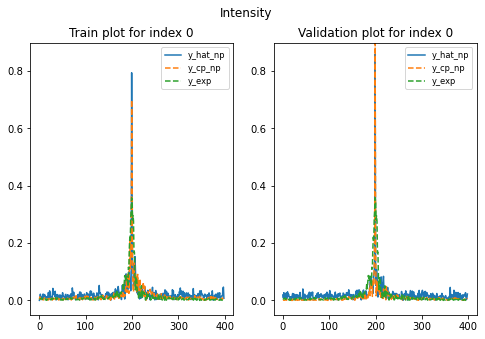

In [25]:
from matplotlib.font_manager import FontProperties
%matplotlib inline

y_hat_v_np_r = np.abs((T_av_v_np@x_hat_v_np))
y_hat_t_np_r = np.abs((T_av_t_np@x_hat_t_np))
# 
y_hat_v_np = y_hat_v_np_r/np.linalg.norm(y_hat_v_np_r)
y_hat_t_np = y_hat_t_np_r/np.linalg.norm(y_hat_t_np_r)

y_cp_v_np_r = np.abs(T_av_v_np@x_cp_v)
y_cp_t_np_r = np.abs(T_av_t_np@x_cp_v)

y_cp_v_np = y_cp_v_np_r/np.linalg.norm(y_cp_v_np_r)
y_cp_t_np = y_cp_t_np_r/np.linalg.norm(y_cp_t_np_r)

x_exp = np.array([1 if i == T_dag_v_np.shape[-1]//2 else 0 for i in range(T_dag_v_np.shape[-1])])
y_exp = np.abs(T_av_v_np@x_exp)
y_exp_n = y_exp/np.linalg.norm(y_exp)

abs_lim = (150,250)

plt.figure(figsize=(8,5))
fontP = FontProperties()
fontP.set_size('small')
plt.subplot(121)
plt.plot(y_hat_t_np , label = 'y_hat_np')
plt.plot(y_cp_t_np, '--' , label = 'y_cp_np')
plt.plot(y_exp_n, '--', label = 'y_exp')
# plt.xlim(abs_lim)
plt.ylim((-0.05, max(np.max(y_hat_t_np), np.max(y_cp_t_np), \
                     np.max(y_hat_v_np), np.max(y_cp_v_np))))
plt.legend(prop=fontP)
plt.title(f"Train plot for index {ind}")
plt.subplot(122)
plt.plot( y_hat_v_np , label = 'y_hat_np')
plt.plot( y_cp_v_np , '--' , label = 'y_cp_np')
plt.plot(y_exp_n, '--', label = 'y_exp')
# plt.xlim(abs_lim)
plt.ylim((-0.05, max(np.max(y_hat_t_np), np.max(y_cp_t_np), \
                     np.max(y_hat_v_np), np.max(y_cp_v_np))))
plt.title(f"Validation plot for index {ind}")
plt.suptitle("Intensity")
plt.legend(prop=fontP)
plt.show()

In [32]:
!pwd

/automount/nfs/curie/bme/oguinebr/DL_RT/deep_speckle
